In [16]:
#1. IMPORTING PACKAGES AND LIBRARIES
%matplotlib inline
%load_ext autoreload
%autoreload 2
from contextlib import suppress
import os
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.io.img_tiles import OSM
from cartopy.io.img_tiles import GoogleTiles as moa
from cycler import cycler
import scipy
import seaborn as sns
import sys
import glob
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import xarray as xr
import pyproj
import osr
import datetime
import subprocess
import shutil
import numpy as np
from ipywidgets import interact
import pandas as pd
import pickle
from scipy.signal import savgol_filter
import time
import statsmodels.api as sm
import statsmodels.formula.api as smf
from pandas.plotting import autocorrelation_plot
from pandas.plotting import lag_plot


#own libary
import nsidc 

from functions_pmrs import loadCM
from functions_pmrs import applyshift
from functions_pmrs import calculateQR
from functions_pmrs import probability
from functions_pmrs import NQT
from functions_pmrs import calc_performance_scores_new


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [80]:
#SELECT BOUNDS AND START / END DATES
bounds = [( -19., 20.),
          (-11., 27.),
         ]

# start_date = datetim.datetime(2002, 5, 29) # Start of the AMSR-E period
# start_date = datetime.datetime(2004, 1, 1) # date after data recovery
# end_date = datetime.datetime(2009, 12, 31)  # only a few days to make a demonstration
# end_date = datetime.datetime(2004, 6, 30)  # use this end date to cover the whole AMSR-E period.
# end_date = datetime.datetime(2002, 1, 2)

#---------------------------#---------------------------#---------------------------#---------------------------#

#Select set of POI's to use

# points = pd.read_csv('poizambeziplain.csv')   #Kalabo (weinig goede resultaten)
points = pd.read_csv('poi_senaga.csv')
# points = pd.read_csv('POIs_RE_3p.csv')


#adjust according to number of points in POI's
points_interest = [(points.xcoord[0],points.ycoord[0]),
                   (points.xcoord[1],points.ycoord[1])]
#                    (points.xcoord[2],points.ycoord[2]),
#                    (points.xcoord[3],points.ycoord[3]),
#                    (points.xcoord[4],points.ycoord[4])]
#                    (points.xcoord[5],points.ycoord[5])]
#                    (points.xcoord[6],points.ycoord[6]) 


# Download discharge data, no adjustment 
# dQ = pd.read_csv('ZAMBEZIDISCHARGE.csv',sep=';',parse_dates=['DATE'],index_col = ['DATE'],na_filter=True)
dQ = pd.read_csv('ZAMBEZIDISCHARGE.csv',sep=';',na_filter=True) #,parse_dates=['DATE'],index_col = ['DATE']
dQ['Date'] = pd.to_datetime(dQ['Date'])



#---------------------------#---------------------------#---------------------------#---------------------------#

# DOWNLOAD THE CORRECT DATA
# This cell calls the right download and "glues" the years together. 

fns=None

year = 2009  #change year to select specific year to see [2002-2011]

# 25 km resolution PMSR DATA
# fns = glob.glob(f'/Users/oscarkeunen/Documents/1. TU Delft/1. Msc - Watermanagement/Afstuderen/satellite-cookbook-master/NSIDC-AMSRE/Sat_Data/25km36ghz/NSIDC_Test_{year}.nc')
#select this next one for full period data string (whole AMSR period)
# fns = glob.glob('/Users/oscarkeunen/Documents/1. TU Delft/1. Msc - Watermanagement/Afstuderen/satellite-cookbook-master/NSIDC-AMSRE/Sat_Data/25km36ghz/*.nc') # select this line to get the whole AMSR-E period

# SAT = 'AMSRE'
SAT = 'DSMP'


#select this next one for full period data string (whole DSMP period)
fns = glob.glob('/Users/oscarkeunen/Documents/1. TU Delft/1. Msc - Watermanagement/Afstuderen/satellite-cookbook-master/NSIDC-AMSRE/Sat_Data/25km36ghz/DMSP/*.nc') # select this line to get the whole AMSR-E period

# 3.125 km resolution PMSR DATA

# fns = glob.glob(f'/Users/oscarkeunen/Documents/1. TU Delft/1. Msc - Watermanagement/Afstuderen/satellite-cookbook-master/NSIDC-AMSRE/Sat_Data/3km36ghz/NSIDC_Test_{year}.nc')
#select this next one for full period data string (whole AMSR period)
# fns = glob.glob('/Users/oscarkeunen/Documents/1. TU Delft/1. Msc - Watermanagement/Afstuderen/satellite-cookbook-master/NSIDC-AMSRE/Sat_Data/3km36ghz/*.nc') # select this line to get the whole AMSR-E period

fns.sort()
ds = xr.open_mfdataset(fns)

#---------------------------#---------------------------#---------------------------#---------------------------#

# Discharge data location
# location = 'Kalabo'  
location = 'Senanga'
# location = 'Lukulu'


#---------------------------#---------------------------#---------------------------#---------------------------#


# TRANSFORMING, NO ADJUSTMENT NEEDED
proj4str = '+proj=cea +lat_0=0 +lon_0=0 +lat_ts=30 +x_0=0 +y_0=0 +ellps=WGS84 +datum=WGS84 +units=m'
# we define a projection object for lat-lon WGS84 (EPSG code 4326)
proj_out = pyproj.Proj(init='epsg:4326')
# we define a projection object for the projection used in the downloaded grids.
proj_in = pyproj.Proj(proj4str)

# here we convert the coordinates in lat-lon into the coordinate system of the downloaded grids.
bounds_xy = nsidc.proj_coords(bounds, proj_out, proj_in)
points_xy = nsidc.proj_coords(points_interest, proj_out, proj_in)
points_x, points_y = zip(*points_xy)

#---------------------------#---------------------------#---------------------------#---------------------------#
sns.set()

<ipython-input-80-6b7a77d4db1f>:66: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  ds = xr.open_mfdataset(fns)
/Users/oscarkeunen/opt/anaconda3/envs/afstuderen/lib/python3.8/site-packages/xarray/backends/api.py:926: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  combined = auto_combine(
/Users/oscarkeunen/opt/anaconda3/envs/afstuderen/lib/python3.8/site-packages/pyproj/crs.py:77: Fu

In [83]:

shift= 14
rollingvalue = 6
selection= 5 # < number of months to be choosen
plot = 0


/Users/oscarkeunen/Documents/1. TU Delft/1. Msc - Watermanagement/Afstuderen/satellite-cookbook-master/NSIDC-AMSRE/functions_pmrs.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[n][df[n]<0] = df[n].fillna(method='bfill',inplace=True)


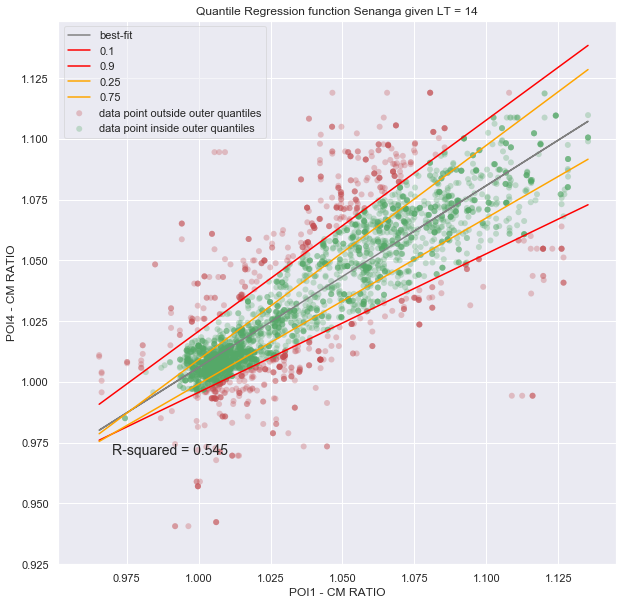

<Figure size 432x288 with 0 Axes>

In [84]:
df = loadCM(points_xy,ds, rollingvalue)


df = applyshift(df,rollingvalue,shift,plot)
# plt.savefig((f'/Users/oscarkeunen/Documents/1. TU Delft/1. Msc - Watermanagement/Afstuderen/satellite-cookbook-master/NSIDC-AMSRE/figures_python/Midterm/Data_{shift}_{location}_{SAT}.png'),dpi=400)


# df= df[df.index.year<2010]
# df= df[df.index.year>2000]
plot=0
df_nqt = NQT(df,plot, shift, location, rollingvalue)
plot=1
df_nqt = df
fits,res = calculateQR(df_nqt,selection,plot,shift,location)
plt.savefig((f'/Users/oscarkeunen/Documents/1. TU Delft/1. Msc - Watermanagement/Afstuderen/satellite-cookbook-master/NSIDC-AMSRE/figures_python/Midterm/QR_{shift}_{location}_{SAT}.png'),dpi=400)
plot=0
pred = probability(df_nqt, fits, plot, shift,location)
# plt.savefig((f'/Users/oscarkeunen/Documents/1. TU Delft/1. Msc - Watermanagement/Afstuderen/satellite-cookbook-master/NSIDC-AMSRE/figures_python/Midterm/Prop_{shift}_{location}_{SAT}.png'),dpi=400)

obs = df_nqt.POI4.values.copy()


In [13]:
percentile=0
threshold = 1.05
dt=10


df_nqt.max()
print(np.nanmax(pred[4]))
print(np.nanmax(obs))


1.1560094812979056
1.135312557220459


In [117]:
## df_nqt = NQT(df,plot, shift, location, rollingvalue) # loading the NQT dataset int the loop, not sure if this is needed
# df_nqt = np.where((df_nqt.index.month == 1) & (df_nqt.index.day == 1))[0] # select only the moment in time the rainseason starts to find the first moment above the trheshold

# obs_threshold = np.where((obs[df_nqt[0]: df_nqt[0]+365]) > threshold)[0]
# obs_threshold = obs_threshold[0] + df_nqt[0]
# print(obs_threshold)
# pred_threshold = np.where(pred[percentile][obs_threshold-dt:obs_threshold+dt] > threshold)[0] + (obs_threshold-dt)
# print(pred_threshold)

performance, output, metric = calc_performance_scores_new(df_nqt, obs, pred, threshold , dt, percentile)
print(metric)

[20.  0.  8.  2.]


<ipython-input-112-678fcce40e41>:43: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if obs_threshold == 0:


In [26]:


def calc_performance_scores_new(df_nqt, obs, pred, threshold , dt, percentile):
    np.seterr(divide='ignore', invalid='ignore')

#     df_nqt = NQT(df,plot, shift, location, rollingvalue) # loading the NQT dataset int the loop, not sure if this is needed
    df_nqt = np.where((df_nqt.index.month == 2) & (df_nqt.index.day == 1))[0] # select only the moment in time the rainseason starts to find the first moment above the trheshold
    performance = np.zeros((len(df_nqt),5)) # create performance matrix 1 = date obs_threshold 2 obs_threshold 3. date pred_thres 4 pred_thres
   
    for t in range (30): # 30 for DSMP data set, 8 for AMSR-E

        obs_threshold = np.where((obs[df_nqt[t]: df_nqt[t]+365]) > threshold)[0] 
#         pred[percentile][obs_threshold] 

        if len(obs_threshold) > 0:   #alles wat groter dan nul is -> hit of een miss
                obs_threshold = obs_threshold[0] + df_nqt[t]
                pred_threshold = np.where(pred[percentile][obs_threshold-dt:obs_threshold+dt] > threshold)[0] + (obs_threshold-dt)
                if len(pred_threshold) > 0: #hit
                    performance [t][0] = obs_threshold  
                    performance [t][1] = 1
                    performance [t][2] = min(pred_threshold)       
                    performance [t][3] = 1          
                else:       # miss!            
                    performance [t][0] = obs_threshold 
                    performance [t][1] = 1           
                    performance [t][2] = len(pred_threshold)
                    performance [t][3] = 0
                               
    

        pred_threshold2 = np.where((pred[percentile][df_nqt[t]: df_nqt[t]+365]) > threshold)[0]
        if len(pred_threshold2)> 0: #alles wat groter dan nul is -> FA of CN
                pred_threshold2 = pred_threshold2[0]  + df_nqt[t]
                obs_threshold2 = np.where(obs[pred_threshold2-dt:pred_threshold2+dt] > threshold)[0]
#                 print(pred_threshold2)
#                 print(obs_threshold2)
                if len(obs_threshold2) == 0: #alles wat groter dan nul is -> FA of CN
                    
                    performance [t][0] = len(obs_threshold2) 
                    performance [t][1] = 0
                    performance [t][2] = pred_threshold2
                    performance [t][3] = 1    
       
    
        if obs_threshold == 0:
            if pred_threshold == 0:
#         if (np.max(obs[df_nqt[t]: df_nqt[t]+365])<threshold): 
#             if (np.max(pred[df_nqt[t]: df_nqt[t]+365])<threshold):                  
                    performance [t][0] = -999
                    performance [t][1] = 0           
                    performance [t][2] = -999
                    performance [t][3] = 0            
    performance =pd.DataFrame(performance)
    
    performance.columns = ['day obs', 'obs', 'day pred', 'pred','class']
    
    hits = len(np.where((performance.obs==1) & (performance.pred ==1))[0])
    false_al = len(np.where((performance.obs==0) & (performance.pred ==1))[0])
    misses = len(np.where((performance.obs==1) & (performance.pred ==0))[0])
    corr_neg = len(np.where((performance.obs==0) & (performance.pred ==0))[0])


    try:
        output = np.zeros((4,))
        output[0] = hits / (hits + misses) #Probability of Detection
        output[1] = false_al / (hits + false_al) #False Alarm Rate
        output[2] = false_al / (false_al + corr_neg) #Probability of fase detection
        output[3] = hits / (hits + false_al + misses) #Critical succes index
    except ZeroDivisionError:
        return -99
    
    metric = np.zeros((4,))
    metric[0] = hits
    metric[1] = false_al
    metric[2] = misses
    metric[3] = corr_neg
    
    return (performance,output,metric)
      
    

<ipython-input-26-678fcce40e41>:43: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if obs_threshold == 0:


[12.  0. 14.  4.]
[17.  1.  8.  4.]
[18.  2.  6.  4.]
[16. 10.  2.  2.]
[14. 15.  0.  1.]
[[0.46153846 0.         0.         0.46153846]
 [0.68       0.05555556 0.2        0.65384615]
 [0.75       0.1        0.33333333 0.69230769]
 [0.88888889 0.38461538 0.83333333 0.57142857]
 [1.         0.51724138 0.9375     0.48275862]]


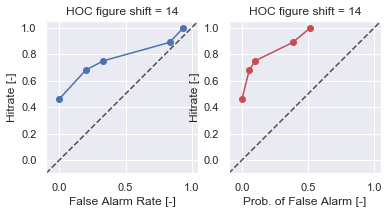

In [32]:
dt =6
shift=14
threshold=1.06
# percentile = 0
df_nqt = NQT(df,plot, shift, location, rollingvalue)
HOC =np.zeros((5,4))
plot=0

for percentile in range(5):

    performance, output, metric = calc_performance_scores_new(df_nqt, obs, pred, threshold , dt, percentile)
#     np.set_printoptions(threshold=np.inf)

#     print(f'percentile from df_nqt {percentile}')
#     print(output)
#     print(performance)
#     print(performance)
#     print(output)
    print(metric)
    HOC [percentile] = output


print(HOC)

    
# print(HOC)     

plt.subplot(1,2,1)
plt.plot(HOC[:,2],HOC[:,0],'-o',color ='b')
plt.xlim([-0.1,1.05])
plt.ylim([-0.1,1.05])
plt.title(f'HOC figure shift = {shift}')
plt.ylabel('Hitrate [-]')
plt.xlabel('False Alarm Rate [-]')
plt.gca().set_aspect('equal', adjustable='box')
plt.plot(plt.xlim(), plt.ylim(), ls="--", c=".3")
plt.draw()

plt.subplot(1,2,2)
plt.plot(HOC[:,1],HOC[:,0],'-o',color ='r')
plt.xlim([-0.1,1.05])
plt.ylim([-0.1,1.05])
plt.title(f'HOC figure shift = {shift}')
plt.ylabel('Hitrate [-]')
plt.xlabel('Prob. of False Alarm [-]')
plt.gca().set_aspect('equal', adjustable='box')
plt.plot(plt.xlim(), plt.ylim(), ls="--", c=".3")
plt.draw()

# plt.savefig((f'/Users/oscarkeunen/Documents/1. TU Delft/1. Msc - Watermanagement/Afstuderen/satellite-cookbook-master/NSIDC-AMSRE/figures_python/Midterm/HOC_{shift}_{location}_{SAT}.png'),dpi=400)




In [71]:
# Run the HOC figures over the threshold bounds
HOC =np.zeros((11,5,4))
shift =14
plot=0
dt=9


df = loadCM(points_xy,ds, rollingvalue)
df = applyshift(df,rollingvalue,shift,plot)

for i, n in enumerate([1.03,1.04,1.05, 1.06,1.07, 1.08,1.09 ,1.10, 1.11, 1.12, 1.13]):#1.14]):
    threshold = n

    df_nqt = NQT(df,plot, shift, location, rollingvalue)
    fits,res = calculateQR(df_nqt,selection,plot,shift,location)
    pred = probability(df_nqt, fits, plot, shift,location)
    obs = df_nqt.POI4.values.copy()
    
    
    for percentile in range (5):
        pred = probability(df_nqt, fits, plot, shift,location)
        obs = df_nqt.POI4.values.copy()
        performance, output, metric = calc_performance_scores_new(df_nqt, obs, pred, threshold , dt, percentile)
        print(metric)
        HOC [i, percentile]= output

HOC



/Users/oscarkeunen/Documents/1. TU Delft/1. Msc - Watermanagement/Afstuderen/satellite-cookbook-master/NSIDC-AMSRE/functions_pmrs.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[n][df[n]<0] = df[n].fillna(method='bfill',inplace=True)


[24.  1.  4.  1.]
[26.  0.  3.  1.]
[26.  1.  2.  1.]
[21.  8.  1.  0.]
[ 9. 21.  0.  0.]
[23.  0.  6.  1.]
[24.  0.  5.  1.]
[26.  0.  3.  1.]
[24.  4.  1.  1.]
[ 9. 21.  0.  0.]
[19.  0.  9.  2.]
[22.  0.  6.  2.]
[22.  1.  5.  2.]
[25.  3.  1.  1.]
[18. 11.  0.  1.]
[15.  0. 11.  4.]
[19.  0.  7.  4.]
[21.  1.  4.  4.]
[20.  5.  3.  2.]
[17. 12.  0.  1.]
[10.  0. 15.  5.]
[14.  0. 11.  5.]
[16.  3.  7.  4.]
[18.  6.  2.  4.]
[15. 12.  1.  2.]
[10.  0. 14.  6.]
[10.  0. 14.  6.]
[16.  1.  7.  6.]
[17.  7.  2.  4.]
[12. 13.  1.  4.]
[ 6.  0. 15.  9.]
[11.  2.  8.  9.]
[11.  3.  7.  9.]
[14.  5.  3.  8.]
[10. 15.  1.  4.]
[ 5.  0. 12. 13.]
[ 6.  1. 10. 13.]
[10.  6.  2. 12.]
[10.  7.  1. 12.]
[ 9. 12.  0.  9.]
[ 3.  0.  8. 19.]
[ 3.  1.  7. 19.]
[ 5.  4.  4. 17.]
[ 5. 11.  1. 13.]
[ 5. 12.  0. 13.]
[ 1.  0.  5. 24.]
[ 1.  0.  5. 24.]
[ 2.  2.  3. 23.]
[ 3.  6.  1. 20.]
[ 4. 12.  0. 14.]


TypeError: cannot unpack non-iterable int object

<ipython-input-72-d4f7a4121bad>:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1,2,1)
<ipython-input-72-d4f7a4121bad>:19: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1,2,2)


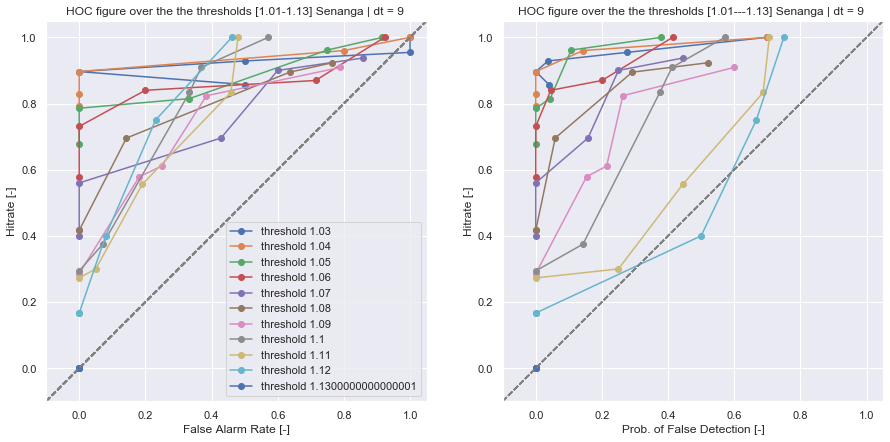

In [72]:
plt.figure(figsize=(15,15))

for n in range (11):

    plt.subplot(1,2,1)
    plt.plot(HOC[n,:,2],HOC[n,:,0],'-o',label=f'threshold {1.03+n*0.01}') #color ='b')
    plt.xlim([-0.1,1.05])
    plt.ylim([-0.1,1.05])
    plt.title(f'HOC figure over the the thresholds [1.01-1.13] {location} | dt = {dt} ')
    plt.ylabel('Hitrate [-]')
    
    plt.plot(plt.xlim(), plt.ylim(), ls="--", c=".5")
    plt.xlabel('False Alarm Rate [-]')
    plt.legend(loc='best')
    plt.gca().set_aspect('equal', adjustable='box')
    plt.draw()


    plt.subplot(1,2,2)
    plt.plot(HOC[n,:,1],HOC[n,:,0],'-o',label=f'threshold {1.03+n*0.01}')#'-o',color ='r')
    plt.xlim([-0.1,1.05])
    plt.ylim([-0.1,1.05])
    plt.title(f'HOC figure over the the thresholds [1.01---1.13] {location} | dt = {dt} ')
    plt.ylabel('Hitrate [-]')
    plt.xlabel('Prob. of False Detection [-]')
    plt.plot(plt.xlim(), plt.ylim(), ls="--", c=".5")
    

    plt.gca().set_aspect('equal', adjustable='box')
#     plt.legend(loc='best')
    plt.draw()  
# plt.savefig((f'/Users/oscarkeunen/Documents/1. TU Delft/1. Msc - Watermanagement/Afstuderen/satellite-cookbook-master/NSIDC-AMSRE/figures_python/Midterm/HOCthreshold_dt{dt}_{location}_{SAT}.png'),dpi=400)


In [73]:
# Run the HOC figures over all the dt positions
HOC =np.zeros((20,5,4))
threshold =1.11
shift= 14

df = loadCM(points_xy,ds, rollingvalue)
df = applyshift(df,rollingvalue,shift,plot)



for i, n in enumerate(range(2, 20, 1)):
    dt = n
    fits,res = calculateQR(df_nqt,selection,plot,shift,location)
    df_nqt = NQT(df,plot, shift, location, rollingvalue)
    pred = probability(df_nqt, fits, plot, shift,location)
    obs = df_nqt.POI4.values.copy()
   
    for percentile in range(5):
        
        pred = probability(df, fits, plot, shift,location)
        obs = df_nqt.POI4.values.copy()
        performance, output, metric = calc_performance_scores_new(df_nqt, obs, pred, threshold , dt, percentile)
        
        HOC [i, percentile]= output



HOC

# plt.figure(figsize=(15,15))
# for n in range (20):

#     plt.plot(HOC[n,:,2],HOC[n,:,0],'-o') #color ='b')
#     plt.xlim([-0.1,1.05])
#     plt.ylim([-0.1,1.05])
#     plt.title(f'HOC figure')
#     plt.ylabel('Hitrate [-]')
#     plt.xlabel('False Alarm Rate [-]')
#     plt.gca().set_aspect('equal', adjustable='box')
#     plt.draw()

#     plt.subplot(1,2,2)
#     plt.plot(HOC[n,:,1],HOC[n,:,0],'-o')#'-o',color ='r')
#     plt.xlim([-0.1,1.05])
#     plt.ylim([-0.1,1.05])
#     plt.title(f'HOC figure  ')
#     plt.ylabel('Hitrate [-]')
#     plt.xlabel('Prob. of False Detection [-]')
#     plt.gca().set_aspect('equal', adjustable='box')
#     plt.draw()

/Users/oscarkeunen/Documents/1. TU Delft/1. Msc - Watermanagement/Afstuderen/satellite-cookbook-master/NSIDC-AMSRE/functions_pmrs.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[n][df[n]<0] = df[n].fillna(method='bfill',inplace=True)


array([[[0.9       , 0.30769231, 0.2       , 0.64285714],
        [0.875     , 0.5625    , 0.40909091, 0.41176471],
        [0.85714286, 0.66666667, 0.52173913, 0.31578947],
        [0.5       , 0.95      , 0.67857143, 0.04761905],
        [0.5       , 0.95454545, 0.75      , 0.04347826]],

       [[0.9       , 0.30769231, 0.2       , 0.64285714],
        [0.875     , 0.5625    , 0.40909091, 0.41176471],
        [0.875     , 0.61111111, 0.5       , 0.36842105],
        [0.8       , 0.8       , 0.64      , 0.19047619],
        [1.        , 0.82608696, 0.73076923, 0.17391304]],

       [[0.9       , 0.30769231, 0.2       , 0.64285714],
        [0.875     , 0.5625    , 0.40909091, 0.41176471],
        [0.875     , 0.61111111, 0.5       , 0.36842105],
        [0.8       , 0.8       , 0.64      , 0.19047619],
        [1.        , 0.82608696, 0.73076923, 0.17391304]],

       [[0.90909091, 0.23076923, 0.15789474, 0.71428571],
        [0.875     , 0.5625    , 0.40909091, 0.41176471],
        

<ipython-input-74-6cbe2b1dc05b>:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1,2,1)
<ipython-input-74-6cbe2b1dc05b>:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1,2,2)


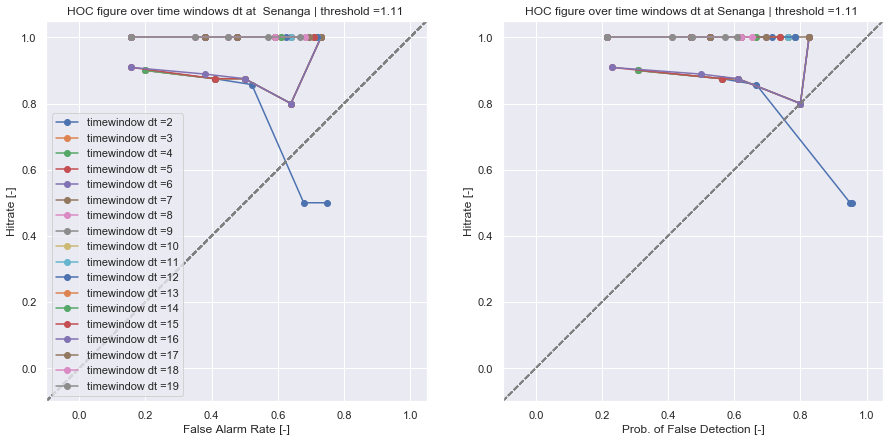

In [74]:
plt.figure(figsize=(15,15))

for n in range (18):

    plt.subplot(1,2,1)
    plt.plot(HOC[n,:,2],HOC[n,:,0],'-o',label= f'timewindow dt ={n+2}') #color ='b')
    plt.xlim([-0.1,1.05])
    plt.ylim([-0.1,1.05])
    plt.title(f'HOC figure over time windows dt at  {location} | threshold ={threshold} ')
    plt.ylabel('Hitrate [-]')
    plt.plot(plt.xlim(), plt.ylim(), ls="--", c=".5")
    plt.xlabel('False Alarm Rate [-]')
    plt.legend(loc='best')
    plt.gca().set_aspect('equal', adjustable='box')
    plt.draw()


    plt.subplot(1,2,2)
    plt.plot(HOC[n,:,1],HOC[n,:,0],'-o',label=f'timewindow dt = {n+2}')#'-o',color ='r')
    plt.xlim([-0.1,1.05])
    plt.ylim([-0.1,1.05])
    plt.title(f'HOC figure over time windows dt at {location} | threshold ={threshold} ')
    plt.ylabel('Hitrate [-]')
    plt.xlabel('Prob. of False Detection [-]')
    plt.plot(plt.xlim(), plt.ylim(), ls="--", c=".5")

    plt.gca().set_aspect('equal', adjustable='box')
#     plt.legend(loc='best')
    plt.draw()  

plt.savefig((f'/Users/oscarkeunen/Documents/1. TU Delft/1. Msc - Watermanagement/Afstuderen/satellite-cookbook-master/NSIDC-AMSRE/figures_python/Midterm/HOC_overdtwiththreshold{threshold}_{location}_{SAT}.png'),dpi=400)


## Function to compute confusion matrix (hits, false alarms, misses, correct negatives) and performance indexes (FAR, POD, POFD, CSI))



Methodology adapted taking into account the consecutive day above thresholds as a unique flood period

hits:              Number of peak period above thresholds that have at least one observation day within the period

false alarm :      number of peak above threshold(consecutive day above discharge threshold as an event), minus the number of hits

misses :           number of observed flood events no in a discharge peak period  above threshold

correct negative : forcing the correct negative number to be the same than the number of observed flood events (misses + hits)



In [402]:
def calc_performance_scores(obs, pred, threshold):

 
    for i in range(len(obs)):
        if obs[i] > threshold:
            obs[i] =1
        else:
            obs[i]=0
            
    for j in range(len(pred)):
        if pred[j] > threshold:
            pred[j] =1
        else:
            pred[j]=0

#     print(obs)
#     print(pred) 

    
    
    hits = len(np.where((obs==1) & (pred ==1))[0])
    false_al = len(np.where((obs==0) & (pred ==1))[0])
    misses = len(np.where((obs==1) & (pred ==0))[0])
    corr_neg = len(np.where((obs==0) & (pred ==0))[0])
    
#     print((hits))
#     print((misses))
#     print((false_al))
#     print((corr_neg))

    output = np.zeros((4,))
    output[0] = hits / (hits + misses) #Probability of Detection
    output[1] = false_al / (hits + false_al) #False Alarm Rate
    output[2] = false_al / (false_al + corr_neg) #Probability of fase detection
    output[3] = hits / (hits + false_al + misses) #Critical succes index


    return output 


#     df= pd.DataFrame({'cons_class': pred.diff().ne(0).cumsum(), 'hits':(obs==1) & (pred ==1)})
#     hits= df[['cons_class','hits' ]].drop_duplicates().hits[df.hits == True].count()
#     false_al = (pred.loc[pred.shift() != pred].sum ()) - hits 
#     misses = sum((obs == 1) & (pred ==0))
#     corr_neg = misses + hits


#     output = {}
#     output['pod'] = hits / (hits + misses) #Probability of Detection
#     output['far'] = false_al / (hits + false_al) #False Alarm Rate
#     output['pofd'] = false_al / (false_al + corr_neg) #Probability of fase detection
#     output['csi'] = hits / (hits + false_al + misses) #Critical succes index
#output=pd.Series(output)


<ipython-input-1085-32b51aa88e9d>:46: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if obs_threshold == 0:


Text(0.5, 0, 'False Alarm Rate [-]')

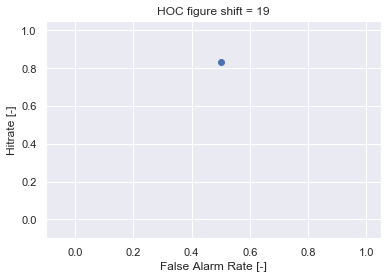

In [1088]:
performance, output = calc_performance_scores_new(df_nqt, obs, pred, threshold , dt,percentile)
output[2]

plt.plot(output[2],output[0],'-o',color ='b')
plt.xlim([-0.1,1.05])
plt.ylim([-0.1,1.05])
plt.title(f'HOC figure shift = {shift}')
plt.ylabel('Hitrate [-]')
plt.xlabel('False Alarm Rate [-]')

In [1116]:
plot=0
df = loadCM(points_xy,ds, rollingvalue)
df = applyshift(df,rollingvalue,shift,plot)
df_nqt = NQT(df,plot, shift, location, rollingvalue)
fits,res = calculateQR(df_nqt,selection,plot,shift,location)
pred = probability(df, fits, plot, shift,location)

obs = df.POI4.values.copy()
# threshold =1

/Users/oscarkeunen/Documents/1. TU Delft/1. Msc - Watermanagement/Afstuderen/satellite-cookbook-master/NSIDC-AMSRE/functions_pmrs.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[n][df[n]<0] = df[n].fillna(method='bfill',inplace=True) #remove any NaN values


/Users/oscarkeunen/Documents/1. TU Delft/1. Msc - Watermanagement/Afstuderen/satellite-cookbook-master/NSIDC-AMSRE/functions_pmrs.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[n][df[n]<0] = df[n].fillna(method='bfill',inplace=True) #remove any NaN values
<ipython-input-1097-ea90abb5e981>:48: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if obs_threshold == 0:
/Users/oscarkeunen/Documents/1. TU Delft/1. Msc - Watermanagement/Afstuderen/satellite-cookbook-master/NSIDC-AMSRE/functions_pmrs.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-

[[0.33333333 0.33333333 0.5        0.28571429]
 [0.66666667 0.2        0.5        0.57142857]
 [1.         0.28571429 0.66666667 0.71428571]
 [1.         0.42857143 0.75       0.57142857]
 [1.         0.57142857 0.8        0.42857143]]


<ipython-input-1097-ea90abb5e981>:48: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if obs_threshold == 0:


Text(0.5, 0, 'Prob. of False Alarm [-]')

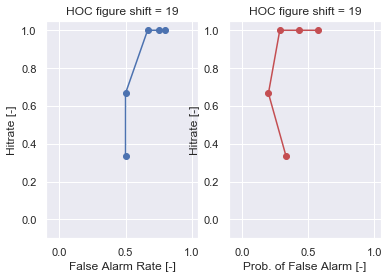

In [1112]:
HOC =np.zeros((5,4))
threshold =1.05
shift=19
plot=0
dt=4


for percentile in range (5):
    df = loadCM(points_xy,ds, rollingvalue)
    df = applyshift(df,rollingvalue,shift,plot)
    fits,res = calculateQR(df,selection,plot,shift,location)
    df_nqt = NQT(df,plot, shift, location, rollingvalue)
    pred = probability(df_nqt, fits, plot, shift,location)
    obs = df.POI4.values.copy()
    
    performance, output = calc_performance_scores_new(df_nqt, obs, pred, threshold , dt,percentile)

#     print(output)
    HOC [percentile]= output
print(HOC)

# # plt.scatter(HOC[1,:],HOC[0,:],color='g')
# # plt.scatter(HOC[2,:],HOC[0,:],color ='r')
plt.figure()


plt.subplot(1,2,1)
plt.plot(HOC[:,2],HOC[:,0],'-o',color ='b')
plt.xlim([-0.1,1.05])
plt.ylim([-0.1,1.05])
plt.title(f'HOC figure shift = {shift}')
plt.ylabel('Hitrate [-]')
plt.xlabel('False Alarm Rate [-]')

plt.subplot(1,2,2)
plt.plot(HOC[:,1],HOC[:,0],'-o',color ='r')
plt.xlim([-0.1,1.05])
plt.ylim([-0.1,1.05])
plt.title(f'HOC figure shift = {shift}')
plt.ylabel('Hitrate [-]')
plt.xlabel('Prob. of False Alarm [-]')



/Users/oscarkeunen/Documents/1. TU Delft/1. Msc - Watermanagement/Afstuderen/satellite-cookbook-master/NSIDC-AMSRE/functions_pmrs.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[n][df[n]<0] = df[n].fillna(method='bfill',inplace=True) #remove any NaN values
/Users/oscarkeunen/Documents/1. TU Delft/1. Msc - Watermanagement/Afstuderen/satellite-cookbook-master/NSIDC-AMSRE/functions_pmrs.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[n][df[n]<0] = df[n].fillna(method='bfill',inplace=True) #remove any NaN values
/Users/oscarkeunen/Documents/1. TU Delft/1. Msc - Watermanagement/Afstuderen/satellite-cookbook-ma

/Users/oscarkeunen/Documents/1. TU Delft/1. Msc - Watermanagement/Afstuderen/satellite-cookbook-master/NSIDC-AMSRE/functions_pmrs.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[n][df[n]<0] = df[n].fillna(method='bfill',inplace=True) #remove any NaN values
<ipython-input-1111-ed340faf8e70>:34: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1,2,2)


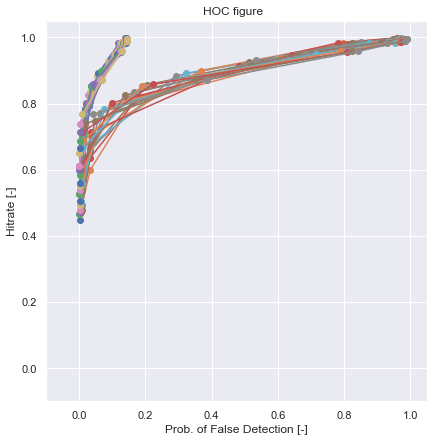

In [1111]:
# Run the HOC figures over all the shift positions
HOC =np.zeros((20,5,4))
threshold =1.0

for i, n in enumerate(range(0, 20, 1)):
    shift = n
    df = loadCM(points_xy,ds, rollingvalue)
    df = applyshift(df,rollingvalue,shift,plot)
    fits,res = calculateQR(df,selection,plot,shift,location)
    df_nqt = NQT(df,plot, shift, location, rollingvalue)
    pred = probability(df_nqt, fits, plot, shift,location)
    obs = df.POI4.values.copy()
    

    for j in range (5):
        output = calc_performance_scores(obs,pred[j],threshold)
        pred = probability(df, fits, plot, shift,location)
        obs = df.POI4.values.copy()
        HOC [i, j]= output
# HOC

plt.figure(figsize=(15,15))
for n in range (20):

    plt.plot(HOC[n,:,2],HOC[n,:,0],'-o') #color ='b')
    plt.xlim([-0.1,1.05])
    plt.ylim([-0.1,1.05])
    plt.title(f'HOC figure')
    plt.ylabel('Hitrate [-]')
    plt.xlabel('False Alarm Rate [-]')
    plt.gca().set_aspect('equal', adjustable='box')
    plt.draw()

    plt.subplot(1,2,2)
    plt.plot(HOC[n,:,1],HOC[n,:,0],'-o')#'-o',color ='r')
    plt.xlim([-0.1,1.05])
    plt.ylim([-0.1,1.05])
    plt.title(f'HOC figure  ')
    plt.ylabel('Hitrate [-]')
    plt.xlabel('Prob. of False Detection [-]')
    plt.gca().set_aspect('equal', adjustable='box')
    plt.draw()

<ipython-input-413-22ce8b41fe54>:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1,2,1)
<ipython-input-413-22ce8b41fe54>:15: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1,2,2)


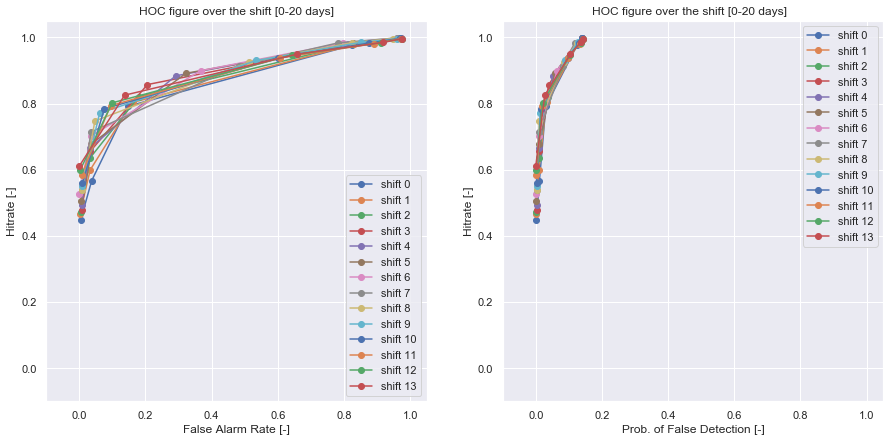

In [413]:
plt.figure(figsize=(15,15))
for n in range (14):

    plt.subplot(1,2,1)
    plt.plot(HOC[n,:,2],HOC[n,:,0],'-o',label=f'shift {n}') #color ='b')
    plt.xlim([-0.1,1.05])
    plt.ylim([-0.1,1.05])
    plt.title(f'HOC figure over the shift [0-20 days] {location}')
    plt.ylabel('Hitrate [-]')
    plt.xlabel('False Alarm Rate [-]')
    plt.legend()
    plt.gca().set_aspect('equal', adjustable='box')
    plt.draw()

    plt.subplot(1,2,2)
    plt.plot(HOC[n,:,1],HOC[n,:,0],'-o',label=f'shift {n}')#'-o',color ='r')
    plt.xlim([-0.1,1.05])
    plt.ylim([-0.1,1.05])
    plt.title(f'HOC figure over the shift [0-20 days] {location} ')
    plt.ylabel('Hitrate [-]')
    plt.xlabel('Prob. of False Detection [-]')
    plt.legend()
    plt.gca().set_aspect('equal', adjustable='box')
    plt.draw()
        
# plt.savefig((f'/Users/oscarkeunen/Documents/1. TU Delft/1. Msc - Watermanagement/Afstuderen/satellite-cookbook-master/NSIDC-AMSRE/figures_python/HOC_Shift{location}.png'),dpi=400)


In [417]:
# Run the HOC figures over the threshold bounds
HOC =np.zeros((5,5,4))
shift =7
for i, n in enumerate([ 0.98, 0.99, 1, 1.01,1.02,1.03,1.04,1.05, 1.06,1.07, 1.08, 1.09 ,1.10, 1.11,1.12,1.13,1.14]):
    threshold = n
    df = loadCM(points_xy,ds, rollingvalue)
    df = applyshift(df,rollingvalue,shift,plot)
    df_nqt = NQT(df,plot, shift, location, roling value)
    fits,res = calculateQR(df_nqt,selection,plot,shift,location)
    pred = probability(df_nqt, fits, plot, shift,location)
    obs = df.POI4.values.copy()
    
    
    for j in range (5):
        output = calc_performance_scores(obs,pred[j],threshold)
        pred = probability(df, fits, plot, shift,location)
        obs = df.POI4.values.copy()
        HOC [i, j]= output
#         output =calc_performance_scores(obs,pred[j],threshold)
# HOC


plt.figure(figsize=(15,15))

for n in range (17):

    plt.subplot(1,2,1)
    plt.plot(HOC[n,:,2],HOC[n,:,0],'-o') #color ='b')
    plt.xlim([-0.1,1.05])
    plt.ylim([-0.1,1.05])
    plt.title(f'HOC figure over the the thresholds [1.01-1.14]')
    plt.ylabel('Hitrate [-]')
    plt.xlabel('False Alarm Rate [-]')
    plt.gca().set_aspect('equal', adjustable='box')
    plt.draw()


    plt.subplot(1,2,2)
    plt.plot(HOC[n,:,1],HOC[n,:,0],'-o')#'-o',color ='r')
    plt.xlim([-0.1,1.05])
    plt.ylim([-0.1,1.05])
    plt.title(f'HOC figure over the the thresholds [1.01-1.14] ')
    plt.ylabel('Hitrate [-]')
    plt.xlabel('Prob. of False Detection [-]')
    plt.gca().set_aspect('equal', adjustable='box')
    plt.draw()  

/Users/oscarkeunen/Documents/1. TU Delft/1. Msc - Watermanagement/Afstuderen/satellite-cookbook-master/NSIDC-AMSRE/functions_pmrs.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[n][df[n]<0] = df[n].fillna(method='bfill',inplace=True)
/Users/oscarkeunen/Documents/1. TU Delft/1. Msc - Watermanagement/Afstuderen/satellite-cookbook-master/NSIDC-AMSRE/functions_pmrs.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[n][df[n]<0] = df[n].fillna(method='bfill',inplace=True)
/Users/oscarkeunen/Documents/1. TU Delft/1. Msc - Watermanagement/Afstuderen/satellite-cookbook-master/NSIDC-AMSRE/functions_pmrs.py:57: Setting

IndexError: index 5 is out of bounds for axis 0 with size 5

In [ ]:
plt.figure(figsize=(15,15))

for n in range (17):

    plt.subplot(1,2,1)
    plt.plot(HOC[n,:,2],HOC[n,:,0],'-o',label=f'threshold {0.98+n*0.01}') #color ='b')
    plt.xlim([-0.1,1.05])
    plt.ylim([-0.1,1.05])
    plt.title(f'HOC figure over the the thresholds [0.98-1.14] {location}')
    plt.ylabel('Hitrate [-]')
    plt.xlabel('False Alarm Rate [-]')
    plt.legend()
    plt.gca().set_aspect('equal', adjustable='box')
    plt.draw()


    plt.subplot(1,2,2)
    plt.plot(HOC[n,:,1],HOC[n,:,0],'-o',label=f'threshold {0.98+n*0.01}')#'-o',color ='r')
    plt.xlim([-0.1,1.05])
    plt.ylim([-0.1,1.05])
    plt.title(f'HOC figure over the the thresholds [0.98-1.14] {location} ')
    plt.ylabel('Hitrate [-]')
    plt.xlabel('Prob. of False Detection [-]')
    plt.gca().set_aspect('equal', adjustable='box')
    plt.legend()
    plt.draw()  
    plt.savefig((f'/Users/oscarkeunen/Documents/1. TU Delft/1. Msc - Watermanagement/Afstuderen/satellite-cookbook-master/NSIDC-AMSRE/figures_python/HOC_threshold{location}.png'),dpi=400)
